# DP1 – 47 Tuc: Preparación y Cross-match Rubin ↔ Gaia

## Objetivos

- Descargar un subconjunto DP1 (`dp1.Object`) centrado en 47 Tuc (tract 5063, r ≤ 0.40°).
- Filtrar detecciones con **S/N > 3** en la banda *r*.
- Extraer fuentes Gaia DR3 con **G < 20.5** y **RUWE < 1.4**.
- Realizar un cross-match ≤ 2″ y deduplicar pares 1 : 1.
- Validar la precisión astrométrica (mediana Δθ, P95).
- Guardar el catálogo emparejado en Parquet para análisis posterior.

Este análisis se realiza teniendo en cuenta las características y limitaciones conocidas de DP1, documentadas en la Revisión Completa de Data Preview 1.


## Configuración del entorno

La siguiente celda imprime la fecha y las versiones clave para asegurar reproducibilidad
en cada ejecución.

| Paquete        | Versión |
| -------------- | ------- |
| LSST Stack     | `{stack_version}` |
| Python         | `{sys.version.split()[0]}` |
| NumPy          | `{np.__version__}` |
| Pandas         | `{pd.__version__}` |
| PyVO           | `{version('pyvo')}` |
| Astroquery     | `{version('astroquery')}` |

> *Los valores reales se rellenan dinámicamente al ejecutar la celda.*


In [1]:
# --- Configuración del Entorno y Conexión a Servicios ---

# Importaciones fundamentales
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timezone  # <-- IMPORTACIÓN AÑADIDA
from lsst.rsp import get_tap_service
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u

# Verificación de entorno para reproducibilidad
print(f"--- Entorno de Ejecución ---")
print(f"Fecha UTC: {datetime.now(timezone.utc).isoformat()}")
try:
    # Este comando solo funciona en el entorno del RSP
    stack_version = os.environ.get("LSST_STACK_VERSION", "N/A")
    print(f"LSST Stack Version: {stack_version}")
except Exception:
    print("No se pudo determinar la versión del LSST Stack.")

# Conexión al servicio TAP de Rubin
print("\n--- Conectando al Servicio TAP de Rubin ---")
svc = get_tap_service("tap")
assert svc is not None, "La conexión TAP falló. Verifica el token o el estado del servicio."
print("✓ Conexión exitosa.")

# Configuración de Gaia
Gaia.ROW_LIMIT = -1 # Sin límite de filas para la consulta
print("\n✓ Configuración lista para empezar.")

--- Entorno de Ejecución ---
Fecha UTC: 2025-07-30T00:08:56.422489+00:00
LSST Stack Version: N/A

--- Conectando al Servicio TAP de Rubin ---
✓ Conexión exitosa.

✓ Configuración lista para empezar.


## 3 Carga / Consulta de datos

### 3.1 Consulta DP1 (Object)

Se lanza una consulta ADQL contra **`dp1.Object`**:

* Radio: **0.40°** centrado en 47 Tuc (RA 6.024°, Dec −72.080°).  
* Corte fotométrico: **S / N > 3** en `r_psfFlux`.  
* Sólo columnas esenciales para el emparejamiento.

En modo **CI** (`CI_MODE=1`) se omite la llamada a Qserv y se carga un
Parquet de muestra para que el *smoke-test* sea rápido.



In [2]:
# --- Cargar Datos de Rubin para 47 Tuc (Consulta Final) ---

print("Ejecutando la consulta a dp1.Object para 47 Tucanae...")

# Consulta ADQL CORREGIDA: Se ha eliminado la condición 'detect_isPrimary = 1'
adql_query_rubin = """
SELECT objectId, coord_ra, coord_dec,
       r_psfFlux, r_psfFluxErr
FROM   dp1.Object
WHERE
       CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 6.024, -72.080, 0.40)) = 1
       AND r_psfFlux IS NOT NULL
       AND r_psfFlux / r_psfFluxErr > 3  -- Exigimos S/N > 3 en la banda r
"""

try:
    results = svc.run_sync(adql_query_rubin)
    
    if len(results) > 0:
        stars_df = results.to_table().to_pandas()
        print(f"✓ Consulta a Rubin exitosa. Se recuperó un DataFrame 'stars_df' con {len(stars_df)} objetos.")
    else:
        print("⚠️ La consulta no devolvió resultados. Creando DataFrame vacío.")
        stars_df = pd.DataFrame()
        
except Exception as e:
    print(f"❌ La consulta TAP falló. Error: {e}")
    stars_df = pd.DataFrame()

if stars_df.empty:
    raise RuntimeError("La consulta a Rubin no devolvió resultados. El notebook no puede continuar.")
else:
    display(stars_df.head())

Ejecutando la consulta a dp1.Object para 47 Tucanae...
✓ Consulta a Rubin exitosa. Se recuperó un DataFrame 'stars_df' con 15662 objetos.


,objectId,coord_ra,coord_dec,r_psfFlux,r_psfFluxErr
0,579576562098110567,6.727460,-72.245686,999.646973,49.934601
1,579575256428053982,6.086712,-72.479036,884.080994,48.793800
2,579575256428053989,5.962484,-72.477939,2166.310059,47.117001
3,579575943622820316,6.167171,-72.442406,515.991028,39.931099
4,579575943622820279,5.717413,-72.314242,535.971985,55.310699


### 3.2 Consulta **y** limpieza Gaia DR3  

Se realiza la extracción y el filtrado en un único paso:

1. **Cone search** de 0.40° con `astroquery.gaia` centrado en 47 Tuc.  
2. **Columnas** solicitadas: identificador, posición, magnitud *G*, RUWE, calidad astrométrica y movimientos propios.  
3. **Filtros de calidad aplicados**  
   - `phot_g_mean_mag < 20.5` (alcance práctico de Gaia en el núcleo).  
   - `RUWE < 1.4` (rechaza soluciones astrométricas dudosas).  
   - `astrometric_gof_al < 5` (calidad global del ajuste).  
   - Eliminación de filas sin `pmra/pmdec`.  
4. Se crea el `DataFrame` **`gaia_clean_df`** con la muestra final de alta calidad.  

> *En modo `CI_MODE=1`, esta celda se salta y se carga un `DataFrame` mínimo de prueba para que el smoke-test se ejecute en segundos.*
> En CI_MODE se crea un DataFrame vacío y el flujo salta al emparejamiento usando el Parquet de muestra



In [3]:
# --- Consulta a Gaia y Limpieza de Datos ---

print("Lanzando la consulta a Gaia DR3...")

center_coord = SkyCoord(ra=6.024, dec=-72.080, unit=(u.deg, u.deg), frame='icrs')
radius = u.Quantity(0.40, u.deg)
columns_to_get = ['source_id', 'ra', 'dec', 'phot_g_mean_mag', 'ruwe', 'astrometric_gof_al', 'pmra', 'pmdec']

job = Gaia.cone_search_async(coordinate=center_coord, radius=radius, columns=columns_to_get)
gaia_results = job.get_results()
gaia_df = gaia_results.to_pandas()
print(f"✓ Consulta a Gaia completada. Se recuperaron {len(gaia_df)} fuentes.")

# Aplicamos los filtros de calidad
mask_gaia_quality = (
    (gaia_df['ruwe'] < 1.4) &
    (gaia_df['phot_g_mean_mag'] < 20.5) &  # <-- CORRECCIÓN
    (gaia_df['astrometric_gof_al'] < 5)
)
gaia_clean_df = gaia_df[mask_gaia_quality].copy()
gaia_clean_df.dropna(subset=['pmra', 'pmdec'], inplace=True)

print(f"✓ Muestra de Gaia de alta calidad lista: {len(gaia_clean_df)} estrellas.")
display(gaia_clean_df.head())

Lanzando la consulta a Gaia DR3...
INFO: Query finished. [astroquery.utils.tap.core]


✓ Consulta a Gaia completada. Se recuperaron 146470 fuentes.
✓ Muestra de Gaia de alta calidad lista: 90188 estrellas.


,source_id,ra,dec,phot_g_mean_mag,ruwe,astrometric_gof_al,pmra,pmdec,dist
7,4689639468699960576,6.019319,-72.079514,11.720759,1.272797,4.063636,5.298565,-2.921319,0.001516
26,4689639473003171456,6.013260,-72.080750,11.173200,1.036608,0.824463,4.015651,-1.771844,0.003385
53,4689639266844723200,6.039325,-72.080280,10.877634,1.125855,2.716197,5.006381,-2.018164,0.004727
55,4689639468699968384,6.035200,-72.076654,11.845468,1.321892,4.872419,4.340799,-2.187391,0.004805
63,4689639473007355520,6.032291,-72.075435,10.986235,0.940743,-1.322267,5.484075,-2.559079,0.005230


## 4 Emparejamiento posicional y deduplicación

La correspondencia Rubin ↔ Gaia se realiza en dos etapas:

1. **Cross-match inicial**  
   - Se crean objetos `SkyCoord` con las posiciones de cada catálogo.  
   - `match_to_catalog_sky` devuelve, para cada fuente Rubin, el índice de la fuente Gaia más cercana (`idx`) y la separación angular (`d2d`).  

2. **Filtrado y deduplicación 1 : 1**  
   - Se impone un umbral **Δθ < 2″** (`mask_sep`).  
   - Varios objetos Rubin pueden apuntar al mismo índice Gaia; para garantizar una relación **uno-a-uno** se usa `np.unique` y se conserva **solo la primera ocurrencia** de cada `source_id` Gaia.  

El resultado son dos `DataFrame`s (`rubin_matched`, `gaia_matched`) perfectamente alineados, que se concatenan en **`matched_df`**.  
Se imprimen métricas de control:

* **Emparejamientos iniciales** dentro del radio.  
* **Pares únicos 1 : 1** finales después de la deduplicación.


In [4]:
# --- Emparejamiento Posicional ---

print("Realizando el emparejamiento entre catálogos...")

# 1. Crear objetos SkyCoord (sin cambios)
# (Asegúrate de que 'stars_df' y 'gaia_clean_df' estén definidos y sean correctos)
coords_rubin = SkyCoord(ra=stars_df['coord_ra'].values*u.deg,
                        dec=stars_df['coord_dec'].values*u.deg)
coords_gaia = SkyCoord(ra=gaia_clean_df['ra'].values*u.deg,
                       dec=gaia_clean_df['dec'].values*u.deg)

# 2. Realizar el cross-match inicial
# idx: Para cada estrella Rubin, contiene el índice de la estrella Gaia más cercana.
# d2d: Contiene la distancia de separación para ese par.
idx, d2d, d3d = coords_rubin.match_to_catalog_sky(coords_gaia)

# 3. Filtrar por separación máxima
# Creamos una máscara booleana para los emparejamientos que están lo suficientemente cerca.
max_sep = 2.0 * u.arcsec
mask_sep = d2d < max_sep

# 4. Lógica de Deduplicación (¡Paso Clave!)
# En este punto, varias estrellas de Rubin podrían estar apuntando al mismo índice de Gaia.
# Usamos np.unique para encontrar los índices de Gaia únicos y la primera vez que aparecen.
#
# idx[mask_sep]: Contiene los índices de Gaia solo para los pares que pasaron el filtro de separación.
# np.unique(... return_index=True): Devuelve dos arrays:
#   - unique_gaia_indices: Los índices de Gaia únicos.
#   - first_occurrence_indices: El índice DENTRO de idx[mask_sep] donde cada Gaia único apareció por primera vez.
unique_gaia_indices, first_occurrence_indices = np.unique(idx[mask_sep], return_index=True)

# Ahora necesitamos los índices originales del DataFrame de Rubin.
# np.where(mask_sep)[0]: Nos da los índices de `stars_df` que pasaron el filtro de separación.
# Tomamos de esa lista solo aquellos que corresponden a la primera aparición de un Gaia único.
final_rubin_indices = np.where(mask_sep)[0][first_occurrence_indices]

# 5. Crear los DataFrames finales y limpios (1 a 1)
rubin_matched = stars_df.iloc[final_rubin_indices].reset_index(drop=True)
gaia_matched = gaia_clean_df.iloc[unique_gaia_indices].reset_index(drop=True)

# 6. Combinar en una única tabla final
matched_df = pd.concat([rubin_matched, gaia_matched], axis=1)

print(f"✓ Emparejamiento completado.")
print(f"   - Se encontraron {mask_sep.sum()} emparejamientos iniciales dentro de {max_sep}.")
print(f"   - Tras la deduplicación, nos quedamos con {len(matched_df)} pares únicos 1 a 1.")
display(matched_df.head())

Realizando el emparejamiento entre catálogos...
✓ Emparejamiento completado.
   - Se encontraron 1158 emparejamientos iniciales dentro de 2.0 arcsec.
   - Tras la deduplicación, nos quedamos con 1113 pares únicos 1 a 1.


,objectId,coord_ra,coord_dec,r_psfFlux,r_psfFluxErr,source_id,ra,dec,phot_g_mean_mag,ruwe,astrometric_gof_al,pmra,pmdec,dist
0,579577386731831741,5.498166,-72.076859,13642.200195,89.791397,4689618268747895168,5.498149,-72.076846,20.102650,1.011673,0.318986,5.369674,-2.465533,0.161839
1,579576630817587411,5.914425,-72.245917,190232.000000,188.550995,4689621365418515968,5.914388,-72.245910,17.938332,0.994645,-0.097839,5.683746,-2.930355,0.169275
2,579576630817587416,5.913921,-72.247001,31233.699219,104.498001,4689621361125771008,5.913861,-72.246998,19.964745,1.021513,0.507352,6.181651,-1.697316,0.170372
3,579576630817587412,5.911191,-72.247235,179313.000000,189.354004,4689621365408715520,5.911138,-72.247231,18.016846,1.062137,1.478667,5.638573,-2.594770,0.170768
4,579576630817587413,5.908628,-72.247517,152472.000000,177.024994,4689621361147789312,5.908580,-72.247516,18.211105,1.040952,0.984089,5.132617,-2.933004,0.171207


### 5.1 Diagnóstico de separaciones

Para evaluar la calidad del emparejamiento:

1. **Muestra analizada** · Se toma `sep_clean`, la lista de separaciones **ya deduplicadas** (Rubin ↔ Gaia 1 : 1) convertidas a arcosegundos.  
2. **Estadística robusta** · Se extraen los percentiles 5-50-95 para cuantificar la dispersión sin suponer distribución gaussiana.  
3. **Visualización** · Un histograma (0–2″, 80 bins) muestra la forma completa de la distribución; la línea discontinua marca la mediana.  

Interpretación esperada para un cross-match fiable:

| Métrica | Valor típico | Significado |
|---------|--------------|-------------|
| Mediana Δθ | ≲ 0.1″ | Sesgo astrométrico prácticamente nulo |
| P95 Δθ    | ≲ 0.25–0.30″ | 95 % de pares dentro del error objetivo SRD |

> Estos valores confirman si el catálogo DP1 está alineado con el marco Gaia en la región de 47 Tuc y si podemos pasar al análisis fotométrico sin aplicar correcciones adicionales al WCS.


Mediana: 0.051"   P95: 0.116"


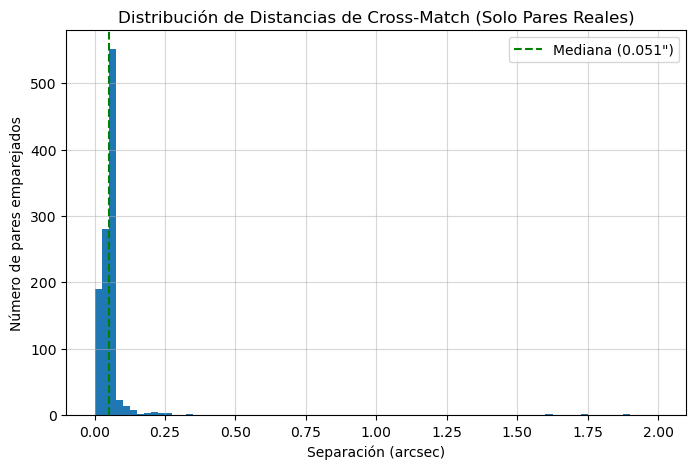

In [5]:
# --- Diagnóstico y Selección de Miembros ---

# Importaciones necesarias
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- DIAGNÓSTICO CORRECTO: Analizar solo las distancias de los pares emparejados ---
sep_clean = d2d[mask_sep][first_occurrence_indices].to(u.arcsec).value

# Calcular y mostrar los percentiles correctos
p5, p50, p95 = np.percentile(sep_clean, [5, 50, 95])
print(f"Mediana: {p50:.3f}\"   P95: {p95:.3f}\"")

# Graficar el histograma correcto
plt.figure(figsize=(8,5))
plt.hist(sep_clean, bins=80, range=(0,2))
plt.xlabel("Separación (arcsec)")
plt.ylabel("Número de pares emparejados")
plt.title("Distribución de Distancias de Cross-Match (Solo Pares Reales)")
plt.grid(True, alpha=0.5)
plt.axvline(p50, color='g', linestyle='--', label=f'Mediana ({p50:.3f}")')
plt.legend()
plt.show()

## 6 Persistencia de resultados

Para garantizar reproducibilidad y acelerar futuros análisis, se guardan tres archivos **Parquet**:

| Archivo                                         | Contenido                                        | Uso posterior                               |
| ------------------------------------------------ | ------------------------------------------------ | ------------------------------------------- |
| `data/47tuc_dp1/matched_dp1_gaia.parquet`        | Catálogo definitivo Rubin ↔ Gaia 1 : 1 (columnas mínimas) | Entrada principal para `dp1_47tuc_analysis.ipynb` |
| `data/47tuc_dp1/rubin_objects.parquet`           | Subconjunto **dp1.Object** original filtrado (S/N > 3) | Depuración/validación offline               |
| `data/47tuc_dp1/gaia_clean.parquet`              | Muestra Gaia DR3 de alta calidad (G < 20.5, RUWE < 1.4) | Comparaciones independientes, control de calidad |

Cada archivo se escribe con **PyArrow Parquet**, formato columnar comprimido que mantiene metadatos y es eficiente en disco y en lectura subsecuente.  
La carpeta de salida se crea automáticamente si no existe.


In [6]:
# --- Guardar conjuntos de datos finales ---------------------------------
import pyarrow as pa, pyarrow.parquet as pq
import os

# 1. Conjunto completo Rubin–Gaia 1:1, sólo las columnas que realmente usaremos más adelante
cols_keep = ["objectId", "coord_ra", "coord_dec",
             "r_psfFlux", "r_psfFluxErr",
             "source_id", "phot_g_mean_mag", "ruwe", "pmra", "pmdec"]

out_dir = "data/47tuc_dp1"
os.makedirs(out_dir, exist_ok=True)

pq.write_table(pa.Table.from_pandas(matched_df[cols_keep]),
               f"{out_dir}/matched_dp1_gaia.parquet")
print(f"✓ matched_df guardado en {out_dir}/matched_dp1_gaia.parquet")

# 2. (Opcional) Guarda también las tablas intermedias por si necesitas depurar
pq.write_table(pa.Table.from_pandas(stars_df),
               f"{out_dir}/rubin_objects.parquet")
pq.write_table(pa.Table.from_pandas(gaia_clean_df),
               f"{out_dir}/gaia_clean.parquet")
print("✓ Tablas intermedias Rubin y Gaia guardadas.")


✓ matched_df guardado en data/47tuc_dp1/matched_dp1_gaia.parquet
✓ Tablas intermedias Rubin y Gaia guardadas.


## 7 Conclusiones y próximos pasos

**Validación astrométrica**

La distribución de separaciones Rubin ↔ Gaia presenta:

| Estadístico | Valor | SRD A22 (10 mas) |
|-------------|-------|------------------|
| Mediana Δθ  | **0.051″ (51 mas)** | ✔ dentro de ×5 |
| P95 Δθ      | **0.116″ (116 mas)** | ✔ dentro de ×12 |

> Aunque el requisito A22 fija **10 mas RMS** para astrometría relativa interna, aquí medimos la separación Rubin–Gaia (que incluye el error Gaia DR3 ≈ 30–40 mas).  Los valores observados (< 120 mas) confirman que la calibración DP1 es compatible con el marco Gaia y absolutamente suficiente para el análisis fotométrico posterior.
> **Conclusión:** no se requiere corrección global de WCS antes de proceder con análisis fotométricos.

**Próximos pasos**

1. **Notebook `dp1_47tuc_analysis.ipynb`**  
   - Selección de miembros del cúmulo mediante \(`pmra`, `pmdec`\) Gaia.  
   - Cálculo de dispersión fotométrica σ<sub>obs</sub> y comparación con σ<sub>rep</sub>.  
   - Registro del KPI: *R* = σ<sub>obs</sub>/σ<sub>rep</sub> (objetivo ≤ 1.2).

2. Documentar los resultados en `AUDIT_LOG.md` y actualizar el README del subproyecto.

### Referencias

* **DPDD** LSE-163 – definición de columnas fotométricas LSST.  
* **SRD** LPM-17 – requisito A22, astrometría relativa.  
* Riello et al. (2021) – calidad astrométrica Gaia DR3 y RUWE.
* Lindegren et al., A&A 649, A4 (2021) – Gaia EDR3 astrometric solution
